In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from tvDatafeed import TvDatafeed, Interval

In [2]:
import requests
import json
import pandas as pd
import datetime

In [3]:
n=1

In [4]:
tv = TvDatafeed()
def getdata(name):
    data=tv.get_hist(symbol=name,exchange='BINANCE',interval=Interval.in_daily,n_bars=5000)
    data=data.reset_index()
#     data["datetime"]=data["datetime"]+datetime.timedelta(days=1)
    data["datetime"]=data["datetime"].dt.strftime('%Y-%m-%d')
    data2=data[data["datetime"]>="2020-01-01"].copy()
    data2["datetime"] = pd.to_datetime(data2["datetime"])
    return data2

you are using nologin method, data you access may be limited


In [5]:
def getapi(api):
    response_API=requests.get(api)
    data=response_API.text
    parse_json=json.loads(data)
    df = pd.json_normalize(parse_json['values'])
    listtime=list(df['x'])
    listtime2=[]
    for i in listtime:
        listtime2.append(datetime.datetime.fromtimestamp(i).strftime('%Y-%m-%d'))
    df['datetime']=pd.Series(listtime2)
    df["datetime"] = pd.to_datetime(df["datetime"])
#     df["datetime"]=df["datetime"]+datetime.timedelta(days=1)
    df=df[df["datetime"]>="2020-01-01"].copy()
    df=df.drop(columns=['x'])
    df.rename(columns={'y':'value'},inplace=True)
    df=df.drop_duplicates(subset=['datetime'])
    return df

In [6]:
bitcoi=getdata('BTCUSDT')
eth=getdata('ETHUSDT')
bnb=getdata('BNBUSDT')
ada=getdata('ADAUSDT')
bitcoi=bitcoi[["datetime","volume","open","high","low","close"]]
bitcoi.tail(5)

,datetime,volume,open,high,low,close
1636,2022-02-07,64872.75710,43839.99,45492.00,42666.00,44042.99
1637,2022-02-08,34428.16729,44043.00,44799.00,43117.92,44372.72
1638,2022-02-09,62351.80208,44372.71,45821.00,43174.01,43495.44
1639,2022-02-10,44971.83585,43495.44,43920.00,41938.51,42373.73
1640,2022-02-11,843.80999,42373.73,42415.45,42221.38,42295.32


In [7]:
number_transactions=getapi('https://api.blockchain.info/charts/n-transactions?timespan=4years&rollingAverage=24hours&format=json&sampled=false')
number_address=getapi('https://api.blockchain.info/charts/n-unique-addresses?timespan=4years&rollingAverage=24hours&format=json&sampled=false')
transaction_second=getapi('https://api.blockchain.info/charts/transactions-per-second?timespan=4years&rollingAverage=24hours&format=json&sampled=false')
transaction_second=transaction_second.groupby(['datetime']).mean().reset_index()
total_bitcoin=getapi('https://api.blockchain.info/charts/total-bitcoins?timespan=4years&rollingAverage=24hours&format=json&sampled=true')
volume_trade=getapi('https://api.blockchain.info/charts/trade-volume?timespan=4years&rollingAverage=24hours&format=json&sampled=false')
hash_rate=getapi('https://api.blockchain.info/charts/hash-rate?timespan=4years&rollingAverage=24hours&format=json&sampled=false')

In [8]:
bitcoin=bitcoi.merge(eth[["datetime","close"]],on='datetime',how='left',suffixes=('_bitcoin', '_eth'))
bitcoin=bitcoin.merge(bnb[["datetime","close"]],on='datetime',how='left')
bitcoin=bitcoin.merge(ada[["datetime","close"]],on='datetime',how='left',suffixes=('_bnb', '_ada'))

In [9]:
data_api=number_transactions.merge(number_address,on='datetime',how='left',suffixes=('_number_transaction', '_number_address'))
data_api=data_api.merge(transaction_second,on='datetime',how='left')
data_api=data_api.merge(total_bitcoin,on='datetime',how='left',suffixes=('_transaction_second', '_total_bitcoin'))

In [10]:
bitcoin=bitcoin.merge(data_api,on='datetime',how='left')
bitcoin.tail(5)

,datetime,volume,open,high,low,close_bitcoin,close_eth,close_bnb,close_ada,value_number_transaction,value_number_address,value_transaction_second,value_total_bitcoin
768,2022-02-07,64872.75710,43839.99,45492.00,42666.00,44042.99,3116.69,407.8,1.176,276850.0,685310.0,2.537674,1.895052e+07
769,2022-02-08,34428.16729,44043.00,44799.00,43117.92,44372.72,3243.94,422.9,1.195,265804.0,663348.0,3.236806,1.895141e+07
770,2022-02-09,62351.80208,44372.71,45821.00,43174.01,43495.44,3072.49,414.7,1.150,260813.0,673697.0,3.135069,1.895230e+07
771,2022-02-10,44971.83585,43495.44,43920.00,41938.51,42373.73,2927.54,400.0,1.079,258595.0,664971.0,3.083160,1.895320e+07
772,2022-02-11,843.80999,42373.73,42415.45,42221.38,42295.32,2927.00,399.0,1.076,NaN,NaN,NaN,NaN


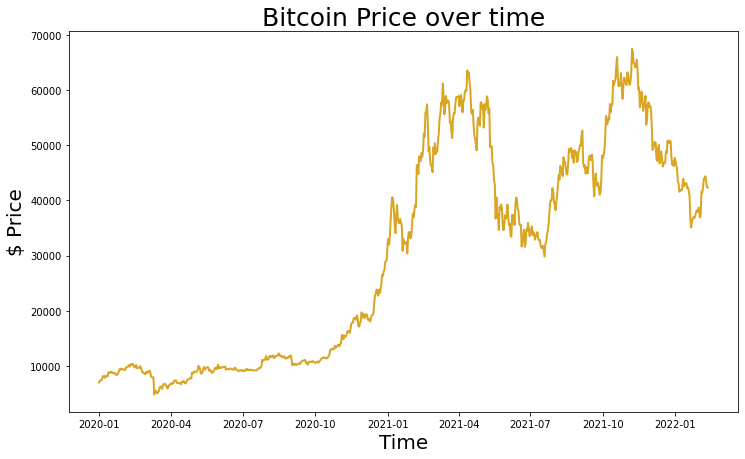

In [11]:
plt.figure(figsize = (12, 7))
plt.plot(bitcoin["datetime"], bitcoin["close_bitcoin"], color='goldenrod', lw=2)
plt.title("Bitcoin Price over time", size=25)
plt.xlabel("Time", size=20)
plt.ylabel("$ Price", size=20)
plt.show()

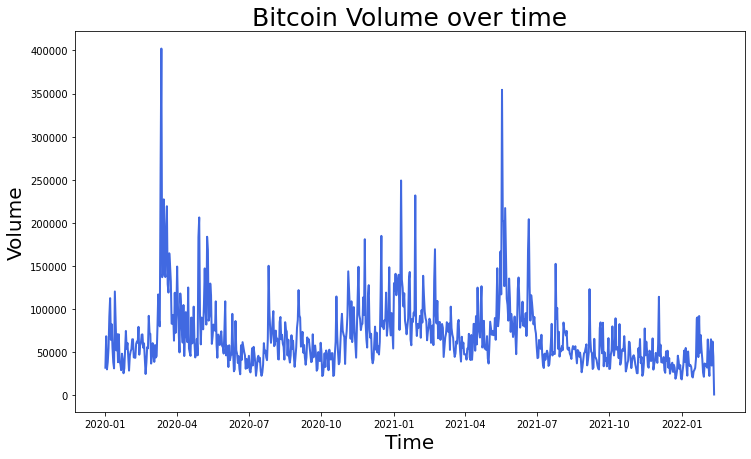

In [12]:
plt.figure(figsize = (12, 7))
plt.plot(bitcoin["datetime"], bitcoin["volume"], color='royalblue', lw=2)
plt.title("Bitcoin Volume over time", size=25)
plt.xlabel("Time", size=20)
plt.ylabel("Volume", size=20);

In [13]:
bitcoin.isnull().sum()

datetime                     0
volume                       0
open                         0
high                         0
low                          0
close_bitcoin                0
close_eth                    0
close_bnb                    0
close_ada                    0
value_number_transaction     1
value_number_address         3
value_transaction_second     1
value_total_bitcoin         39
dtype: int64

In [14]:
# bitcoin=bitcoin.interpolate(method='linear')
temp=bitcoin["datetime"]
bitcoin=bitcoin.drop(columns=['datetime'])
bitcoin=bitcoin.interpolate()
bitcoin['datetime']=temp
bitcoin.isnull().sum()

volume                      0
open                        0
high                        0
low                         0
close_bitcoin               0
close_eth                   0
close_bnb                   0
close_ada                   0
value_number_transaction    0
value_number_address        0
value_transaction_second    0
value_total_bitcoin         0
datetime                    0
dtype: int64

In [15]:
required_features = ['volume','open', 'high', 'low','close_eth','close_bnb','close_ada','value_number_transaction','value_number_address','value_transaction_second','value_total_bitcoin']
output_label = 'close_bitcoin'

In [16]:
x_train, x_test, y_train, y_test = train_test_split(bitcoin[required_features],bitcoin[output_label],test_size = 0.2)

In [17]:
x_test

,volume,open,high,low,close_eth,close_bnb,close_ada,value_number_transaction,value_number_address,value_transaction_second,value_total_bitcoin
550,64123.874245,35288.13,35293.78,33125.55,2196.53,302.0200,1.40390,223760.0,547735.0,2.100174,1.874737e+07
750,88860.891999,40680.92,41100.00,35440.45,2568.15,383.9000,1.12000,272348.0,721363.0,3.115451,1.893451e+07
341,61626.947614,19166.90,19294.84,18200.00,554.94,27.6705,0.14120,330970.0,737193.0,2.962847,1.856432e+07
630,48699.576550,43546.37,44978.00,43069.09,3152.50,383.5000,2.32700,268689.0,642773.0,3.012500,1.882252e+07
252,58253.753750,10219.29,10483.35,10070.83,367.93,24.5489,0.09709,345981.0,745318.0,3.820312,1.848413e+07
...,...,...,...,...,...,...,...,...,...,...,...
362,69411.592606,27079.42,27410.00,25880.00,732.00,39.0667,0.19067,336311.0,775919.0,3.461806,1.858304e+07
182,45725.168076,9231.99,9261.96,8940.00,226.46,15.3634,0.09291,339469.0,674745.0,3.734549,1.841915e+07
608,49904.655280,47100.89,49156.00,46512.00,3826.82,489.4000,2.86900,280865.0,682571.0,3.010590,1.880206e+07
379,118300.920916,39145.21,39747.76,34408.00,1168.53,40.8668,0.30188,344002.0,808283.0,3.854861,1.859998e+07


In [18]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [19]:
model.score(x_test, y_test)

0.9987013265571355

In [20]:
future_set = bitcoin.tail(n).copy()

In [21]:
prediction = model.predict(future_set[required_features])
prediction

array([42127.93076071])

In [22]:
today = datetime.date.today()
tomorrow = today + datetime.timedelta(days=1)
tmr = tomorrow.strftime("%B %d, %Y")
print("The prediction of bitcoin price on",tmr,"at 7 P.M. is",prediction[0])

The prediction of bitcoin price on February 12, 2022 at 7 P.M. is 42127.93076071086
